# Expansión térmica del agua

El coeficiente de dilatación térmica está definido por la siguiente relación
$$
\gamma = \frac{1}{V_0}\frac{\Delta V}{\Delta T} \\
\Rightarrow \Delta V = V_0 \gamma  \Delta T 
$$


El volumen total de agua $V$ dentro del tubo de ensayo se puede escribir como $V = V_0 + V_{\text{capilar}}$, donde  $ V_{\text{capilar}} $ es volumen medido en el capilar hasta el nivel de agua, desde la marca determinada como el volumen inicial, es decir, la columna medida $h$ por el área transversal interna del capilar $\pi d^2/4$.  

De lo anterior se tiene que $$\Delta V = \Delta V_{\text{capilar}} =\pi\frac{d^2}{4}\Delta h$$

Juntando esta ecuación con la definición de $\gamma$, se tiene que

$$
    \pi\frac{d^2}{4}\Delta h = V_0 \gamma  \Delta T \\
    \Rightarrow \Delta h =   \frac{4V_0 \gamma}{d^2\pi} \Delta T
$$

La linealización de los datos arroja la relación $h = a (T - T_0)$, por lo tanto $\Delta h = a$, y final mente 

$$ a = \frac{4V_0 \gamma}{d^2\pi} $$
$$  \Rightarrow \gamma = a\frac{d^2\pi}{4V_0} $$


## Descripción experimental
Se inicia con el nivel en 6 marcas. La temperatura se mide con un termistor $\text{Pt}100$. $h$ está dado en milímetros y $R$ en $\text{k}\Omega$.

Radio interno del capilar $0.12\text{cm}$

## Resultados

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

from sympy.parsing.sympy_parser import parse_expr
from sympy import latex
from sympy import Symbol, latex, diff, sympify
from sympy.core.numbers import Float, Integer

In [2]:
class LinModel():
    def __init__(self, dataframe, xlabel='x', ylabel='y', label='', x_units='', y_units='', round_figures=3, rename_x='', x0_form=False):
        self.model_label = label 
        self.x_units = x_units
        self.y_units = y_units
        self.x_var = dataframe[xlabel].copy()
        self.y_var = dataframe[ylabel].copy()
        
        self.fit()
        
        self.pars = self.vars_stat_summary[['Parámetro', 'Valor estimado']].set_index('Parámetro')
        
        if x0_form == True:
            b = self.pars.loc['b']
            m = self.pars.loc['m']
            x0 = - b/m 
            self.pars.loc[xlabel + '0'] = x0
            self.rhs = sympify('m *(' + xlabel + ' - ' + xlabel + '0)')  if rename_x == '' else sympify('m *(' + rename_x + ' - ' + xlabel + '0)')
            
            rhs = str(self.rhs)
            
            format_string = "{:." + str(round_figures) + "f}"
            rhs = rhs.replace('m', str(format_string.format(m['Valor estimado'])))
            rhs = rhs.replace('T0', str(format_string.format(x0['Valor estimado'])))
            self.rhs_subs = sympify(rhs, evaluate=False)
        else: 
            self.rhs = sympify('m *' + xlabel + ' + b') if rename_x == '' else sympify('m *' + rename_x + ' + b')
            self.rhs_subs = self.rhs.subs(self.pars.transpose().round(round_figures).items())
         
        self.lhs = sympify(ylabel + '(' + xlabel + ')')   
        self.expression = str(self.lhs) + ' = ' + str(self.rhs_subs)
        self.ln_expression = latex(self.lhs) + ' = ' + latex(self.rhs_subs)

    def fit(self):
        def stat_error(std, dof):
            t_95 = t.isf(0.025, dof)
            return std*t_95

        coefficients, covariance_matrix = np.polyfit(self.x_var, self.y_var, 1, cov=True)
        self.slope, self.intercept = coefficients
        
        dof = len(self.x_var)-2 # degrees of freedom
        std_slope, std_intercept = np.abs(np.sqrt(np.diag(covariance_matrix)))
        unc_slope, unc_intercept = (stat_error(std_slope, dof), stat_error(std_intercept, dof))
        cov = covariance_matrix[0,1]
        
        x_min = self.x_var.min()
        x_max = self.x_var.max()
        #interval_length = x_max - x_min
        prediction_func = lambda x: self.slope*x + self.intercept
        
        y_predicted = prediction_func(self.x_var) # f_i = f(x_i)
        ss_res = np.sum((self.y_var - y_predicted)**2)
        ss_tot = np.sum((self.y_var - self.y_var.mean())**2)
                
        pearson_correlation = cov/std_intercept/std_slope
        coef_of_determination = 1 - ss_res/ss_tot
        
        # Falta añadir el error experimental, solo se reporta el estadístico!
        
        self.fit_summary = pd.Series(
            data={
                'Pearson correlation r': pearson_correlation,
                'Coefficient of determination R^2': coef_of_determination
            })

        self.vars_stat_summary = pd.DataFrame(
            data={
                'Parámetro' : ['m', 'b'], 
                'Valor estimado':[self.slope, self.intercept],
                'Error estándar': [std_slope, std_intercept], 
                'Incertidumbre':[unc_slope, unc_intercept]
            })
        
    def f_model(self, x):
        return self.slope*x + self.intercept
    
    def plot(self, ax=None, xlabel='', ylabel='', color = (0,0,0.8), legend=True, show_expression=True, data_label=''):
        label = self.model_label
        if type(ax) == type(None):
            _, ax = plt.subplots(1,1)
            
        x = self.x_var
        y = self.y_var

        x_min = x.min()
        x_max = x.max()
        
        x_grid = np.linspace(x_min, x_max, 100)
        y_model = self.f_model(x_grid)
        
        if xlabel == '':
            xlabel += x.name
        if ylabel == '':
            ylabel += y.name
        curve_label = '$' + str(ylabel) + ' = ' +str(self.rhs_subs) + '$' if show_expression is True else ''
        curve_label = '$' + self.ln_expression + '$'
        
        if self.x_units != '':
            xlabel +=  ' (' + self.x_units + ')'
        if self.y_units != '':
            ylabel += ' (' + self.y_units + ')'
                
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        ax.errorbar(x=x, y=y, marker = '.', ls='', ms='5', color = color, label=data_label)
        ax.plot(x_grid, y_model, color=(*color, 0.3), ls='-', label=curve_label)
        if legend is True:
            ax.legend()

In [3]:
data_1 = pd.read_csv('data_1.csv')
data_2 = pd.read_csv('data_2.csv')
data_hervida = pd.read_csv('data_hervida.csv')

R_vs_T = pd.read_csv('R_vs_T.csv')

# Temperatura vs resistencia para el Pt100
R_vs_T['log(R/R0)'] = (R_vs_T['R']/R_vs_T.R.min()).apply(np.log)
R_vs_T_model = LinModel(R_vs_T, xlabel='log(R/R0)', ylabel='T', y_units='°C', round_figures=5)

# T = T(R); [R] = kilo ohmns, [T] = °C
T = lambda R: R_vs_T_model.f_model(np.log(R/R_vs_T.R.min()))

data_1['T'] = (data_1.R*1000).apply(T)
data_2['T'] = (data_2.R*1000).apply(T)
data_hervida['T'] = (data_hervida.R*1000).apply(T)

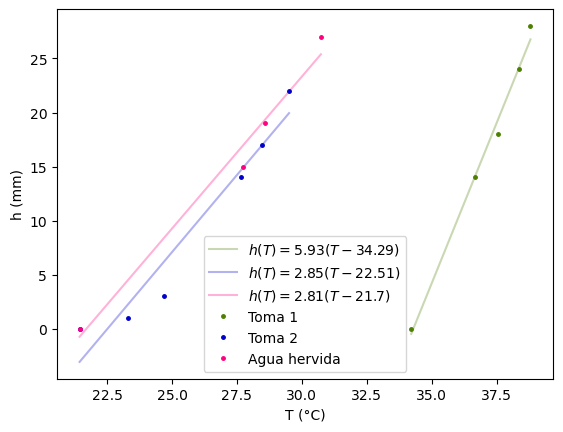

In [4]:
data_model_1 = LinModel(data_1, xlabel='T', ylabel='h', x_units='°C', y_units='mm', round_figures=2, x0_form=True)
data_model_2 = LinModel(data_2, xlabel='T', ylabel='h', x_units='°C', y_units='mm', round_figures=2, x0_form=True)
data_model_hervida = LinModel(data_hervida, xlabel='T', ylabel='h', x_units='°C', y_units='mm', round_figures=2, x0_form=True)

fig, ax = plt.subplots(1,1)
data_model_1.plot(ax=ax, color = (0.3,0.5,0), data_label='Toma 1')
data_model_2.plot(ax=ax, data_label='Toma 2')
data_model_hervida.plot(ax=ax, color=(1,0,0.5), data_label='Agua hervida')

In [5]:
print(data_model_1.fit_summary)
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print(data_model_2.fit_summary)
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print(data_model_hervida.fit_summary)

Pearson correlation r              -0.999041
Coefficient of determination R^2    0.992055
dtype: float64
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Pearson correlation r              -0.993736
Coefficient of determination R^2    0.941187
dtype: float64
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Pearson correlation r              -0.991969
Coefficient of determination R^2    0.981316
dtype: float64


Con $d=1.2\text{ mm}$, $V0 = 50 \cdot 1000 \text{ mm}^3$ y los valores de las pendientes se tienen los siguientes valores para $\gamma$

In [19]:
d = 1.2 # diametro interno del capilar en milímetros
V0 = 50 * 1000
gamma_values = [d**2*np.pi/4/V0*model.pars.loc['m']['Valor estimado'] for model in (data_model_1, data_model_2, data_model_hervida)]

print('Toma 1: ', "{:.3e}".format(gamma_values[0]))
print('Toma 2: ', "{:.3e}".format(gamma_values[1]))
print('Agua hervida: ', "{:.3e}".format(gamma_values[2]))

Toma 1:  1.341e-04
Toma 2:  6.448e-05
Agua hervida:  6.354e-05
